In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-1/DJI_0835.JPG
/kaggle/input/dataset-1/DJI_0117.JPG
/kaggle/input/dataset-1/DJI_0644.JPG
/kaggle/input/dataset-1/DJI_0498.JPG
/kaggle/input/dataset-1/DJI_0429.JPG
/kaggle/input/dataset-1/DJI_0704.JPG
/kaggle/input/dataset-1/DJI_0596.JPG
/kaggle/input/dataset-1/DJI_0556.JPG
/kaggle/input/dataset-1/DJI_0102.JPG
/kaggle/input/dataset-1/DJI_0370.JPG
/kaggle/input/dataset-1/DJI_0054.JPG
/kaggle/input/dataset-1/DJI_0610.JPG
/kaggle/input/dataset-1/DJI_0027.JPG
/kaggle/input/dataset-1/DJI_0042.JPG
/kaggle/input/dataset-1/DJI_0468.JPG
/kaggle/input/dataset-1/DJI_0509.JPG
/kaggle/input/dataset-1/DJI_0731.JPG
/kaggle/input/dataset-1/DJI_0880.JPG
/kaggle/input/dataset-1/DJI_0423.JPG
/kaggle/input/dataset-1/DJI_0178.JPG
/kaggle/input/dataset-1/DJI_0560.JPG
/kaggle/input/dataset-1/DJI_0328.JPG
/kaggle/input/dataset-1/DJI_0631.JPG
/kaggle/input/dataset-1/DJI_0873.JPG
/kaggle/input/dataset-1/DJI_0346.JPG
/kaggle/input/dataset-1/DJI_0388.JPG
/kaggle/input/dataset-1/DJI_0900.JPG
/

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/dataset-1'
test_dir = '/kaggle/input/test-dataset'

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# model = load_model('glof_resnet_model.h5')

img_path = '/kaggle/input/test-dataset/DJI_0997.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize

prediction = model.predict(img_array)

vulnerable = prediction[0][0] > 0.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [9]:
import matplotlib.pyplot as plt
import folium
from folium import plugins

lat, lon = 28.0, 85.0  # Example coordinates

mymap = folium.Map(location=[lat, lon], zoom_start=12)

if vulnerable:
    folium.CircleMarker(location=[lat, lon],
                        radius=50,
                        color='red',
                        fill=True,
                        fill_color='red',
                        fill_opacity=0.6,
                        popup='Vulnerable Region: High Risk').add_to(mymap)
else:
    folium.CircleMarker(location=[lat, lon],
                        radius=50,
                        color='green',
                        fill=True,
                        fill_color='green',
                        fill_opacity=0.6,
                        popup='Vulnerable Region: Low Risk').add_to(mymap)

mymap.save('glof_prediction_map.html')


In [10]:
from IPython.display import display, HTML

display(HTML('<iframe src="glof_prediction_map.html" width="100%" height="500"></iframe>'))


/opt/conda/lib/python3.10/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [24]:
import ee

ee.Initialize()
sikkim = ee.Geometry.Polygon([
    [
        [88.009, 27.307],
        [88.009, 28.112],
        [88.933, 28.112],
        [88.933, 27.307]
    ]
])

rivers = ee.FeatureCollection("WWF/HydroSHEDS/v1/FreeFlowingRivers")
rivers_sikkim = rivers.filterBounds(sikkim)

geemap.ee_export_vector(rivers_sikkim, filename='/kaggle/working/rivers_sikkim.geojson')

Generating URL ...
Please wait ...
Data downloaded to /kaggle/working/rivers_sikkim.geojson


In [35]:
# rivers = ee.FeatureCollection("WWF/HydroSHEDS/v1/FreeFlowingRivers")
# rivers_sikkim = rivers.filterBounds(sikkim)
# print('Rivers in Sikkim:', rivers_sikkim.size().getInfo())

In [41]:
# flood_data = gpd.read_file('/kaggle/working/rivers_sikkim.geojson')
# print(flood_data.head())
# flood_data.to_file('/kaggle/working/processed_flood_data.geojson', driver='GeoJSON')
# flood_data.to_file('/kaggle/working/processed_flood_data.shp')

                     id  CSI_FFID    URB  BB_LEN_KM CSI_D  LENGTH_KM  CON_ID  \
0  00690000000000000459   2036787  1.786    336.668   URB      2.009     5.0   
1  00690000000000002837   2046939  0.476     17.654   URB      2.269     5.0   
2  0069000000000000045e   2036787  0.000    336.668   NAN      0.463     5.0   
3  00690000000000000b21   2112067  0.000    307.260   NAN     11.906     5.0   
4  00690000000000000c24   2066109  0.000     47.328   NAN      1.027     5.0   

   OBJECTID    RDD COUNTRY  ...  Shape_Leng            NUOID BAS_NAME  SED  \
0   1500701  1.688   China  ...    0.018393  3965734_3965735   Ganges  0.0   
1   1499639  0.250   China  ...    0.021844  3964961_3966019   Ganges  0.0   
2   1504041  0.000   China  ...    0.004167  3969832_3969833   Ganges  0.0   
3   1469720  0.000   China  ...    0.117616                    Ganges  0.0   
4   1469947  0.000   China  ...    0.010059  3936043_3936588   Ganges  0.0   

      NOID  RIV_ORD    BB_ID  INC    FLD  \
0  396

In [27]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(sikkim) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
    .filterDate('2023-01-01', '2023-12-31') \
    .median()

sentinel1_sikkim = sentinel1.clip(sikkim)
print('Sentinel-1 SAR Data:', sentinel1_sikkim.getInfo())

Sentinel-1 SAR Data: {'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3, 3], 'origin': [87, 26], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [3, 3], 'origin': [87, 26], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [3, 3], 'origin': [87, 26], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[88.009, 27.307], [88.933, 27.307], [88.933, 28.112], [88.009, 28.112], [88.009, 27.307]]]}}}


In [33]:
import folium

sikkim_geojson = sikkim.getInfo()
m = folium.Map(location=[27.6, 88.5], zoom_start=9)
folium.GeoJson(sikkim_geojson, name='Sikkim').add_to(m)

m.save('sikkim_rivers_map.html')
m

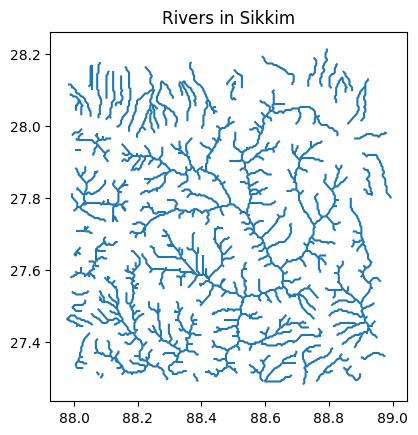

In [76]:
import geopandas as gpd

rivers_df = gpd.read_file('/kaggle/working/rivers_sikkim.geojson')

# Plot the rivers using GeoPandas
rivers_df.plot()
plt.title('Rivers in Sikkim')
plt.show()


In [20]:
# !pip install geemap
# !pip install gdown

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 67.6 MB/s eta 0:00:00:00:01
  Created wheel for pyperclip: filename=pyperclip-1.9.0-py3-none-any.whl size=11002 sha256=fbbc024da9e09fac9a4eae502d7757ff23f9b524df55e61c57bda948de50c484
  Stored in directory: /root/.cache/pip/wheels/cc/ae/36/ee17d1de094fcb61e24106cb329b5103861e819f94bef5e10a
Successfully built pyperclip


In [39]:
# import geemap

# rivers_df = geemap.ee_to_geopandas(rivers_sikkim)

# rivers_df.plot()
# plt.title('Rivers in Sikkim')
# plt.show()

# geemap.ee_export_vector(rivers_sikkim, filename='/kaggle/working/sikkim_rivers.shp')
# geemap.ee_export_image(sentinel1_sikkim, filename='/kaggle/working/sikkim_sentinel1.tif', scale=10)


AttributeError: module 'geemap' has no attribute 'ee_to_geopandas'

In [54]:
import time 
# import gdown
import geemap

In [56]:
# sikkim = ee.Geometry.Polygon([
#     [
#         [88.009, 27.307],
#         [88.009, 28.112],
#         [88.933, 28.112],
#         [88.933, 27.307]
#     ]
# ])

# # Fetch Sentinel-1 SAR data for the specified ROI
# sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
#     .filterBounds(sikkim) \
#     .filterDate('2024-01-01', '2024-01-31') \
#     .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
#     .filter(ee.Filter.eq('instrumentMode', 'IW')) \
#     .mean()  # Compute the mean image over the specified period

# flood_indicator = sentinel1.gt(0.5)  

# # Define export task
# task = ee.batch.Export.image.toDrive(
#     image=flood_indicator,
#     description='flood_data_sikkim',
#     scale=10,  # Sentinel-1 imagery resolution
#     region=sikkim.getInfo()['coordinates'],
#     fileNamePrefix='flood_data_sikkim',
#     folder='Kaggle'  
#     # This will create a folder named 'Kaggle' in Google Drive
# )

# # Start the export task
# task.start()

# # Check the status of the export task
# print('Exporting...')

# # Monitor the task status
# import time
# while task.status()['state'] in ['READY', 'RUNNING']:
#     print('Task status:', task.status())
#     time.sleep(10)

# print('Task status:', task.status())

# print('Check Google Drive for exported file and download it manually if needed.')


Exporting...
Task status: {'state': 'READY', 'description': 'flood_data_sikkim', 'priority': 100, 'creation_timestamp_ms': 1725184854766, 'update_timestamp_ms': 1725184854766, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': '2L7XC4FA6ZRHY6AGIJ3QYO57', 'name': 'projects/earthengine-legacy/operations/2L7XC4FA6ZRHY6AGIJ3QYO57'}
Task status: {'state': 'RUNNING', 'description': 'flood_data_sikkim', 'priority': 100, 'creation_timestamp_ms': 1725184854766, 'update_timestamp_ms': 1725184866545, 'start_timestamp_ms': 1725184863905, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': '2L7XC4FA6ZRHY6AGIJ3QYO57', 'name': 'projects/earthengine-legacy/operations/2L7XC4FA6ZRHY6AGIJ3QYO57'}
Task status: {'state': 'RUNNING', 'description': 'flood_data_sikkim', 'priority': 100, 'creation_timestamp_ms': 1725184854766, 'update_timestamp_ms': 1725184866545, 'start_timestamp_ms': 1725184863905, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': '2L7XC4FA6ZRHY6AGIJ3QYO57', 'name': 'projects/earthengin

KeyboardInterrupt: 

In [62]:
sikkim = ee.Geometry.Polygon([
    [
        [88.009, 27.307],
        [88.009, 28.112],
        [88.933, 28.112],
        [88.933, 27.307]
    ]
])

sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(sikkim) \
    .filterDate('2024-01-01', '2024-01-31') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .mean()  

flood_indicator = sentinel1.gt(0.5)  

export_params = {
    'image': flood_indicator,
    'description': 'flood_data_sikkim',
    'fileNamePrefix': 'flood_data_sikkim',
    'scale': 10,  
    'region': sikkim.getInfo()['coordinates'],
    'fileFormat': 'GeoTIFF'
}

task = ee.batch.Export.image.toDrive(**export_params)
task.start()

import time
import os

print('Exporting...')

while task.status()['state'] in ['READY', 'RUNNING']:
    print('Task status:', task.status())
    time.sleep(10)

print('Task status:', task.status())

print('Check Google Drive for the exported file.')

Exporting...
Task status: {'state': 'READY', 'description': 'flood_data_sikkim', 'priority': 100, 'creation_timestamp_ms': 1725185414748, 'update_timestamp_ms': 1725185414748, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'FNLMXLKUCBWFDBJU3FK5RGM4', 'name': 'projects/earthengine-legacy/operations/FNLMXLKUCBWFDBJU3FK5RGM4'}
Task status: {'state': 'RUNNING', 'description': 'flood_data_sikkim', 'priority': 100, 'creation_timestamp_ms': 1725185414748, 'update_timestamp_ms': 1725185421438, 'start_timestamp_ms': 1725185418170, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'FNLMXLKUCBWFDBJU3FK5RGM4', 'name': 'projects/earthengine-legacy/operations/FNLMXLKUCBWFDBJU3FK5RGM4'}
Task status: {'state': 'RUNNING', 'description': 'flood_data_sikkim', 'priority': 100, 'creation_timestamp_ms': 1725185414748, 'update_timestamp_ms': 1725185421438, 'start_timestamp_ms': 1725185418170, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'FNLMXLKUCBWFDBJU3FK5RGM4', 'name': 'projects/earthengin

KeyboardInterrupt: 

In [65]:
# import gdown

# file_id = 'flood_data_sikkim.tif'
# output_file = '/kaggle/working/flood_data_sikkim.tif'
# file_url = f'https://drive.google.com/uc?id={file_id}'

# gdown.download(file_url, output_file, quiet=False)

# import os
# print('File saved in Kaggle working directory:', os.listdir('/kaggle/working'))


FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=flood_data_sikkim.tif

but Gdown can't. Please check connections and permissions.

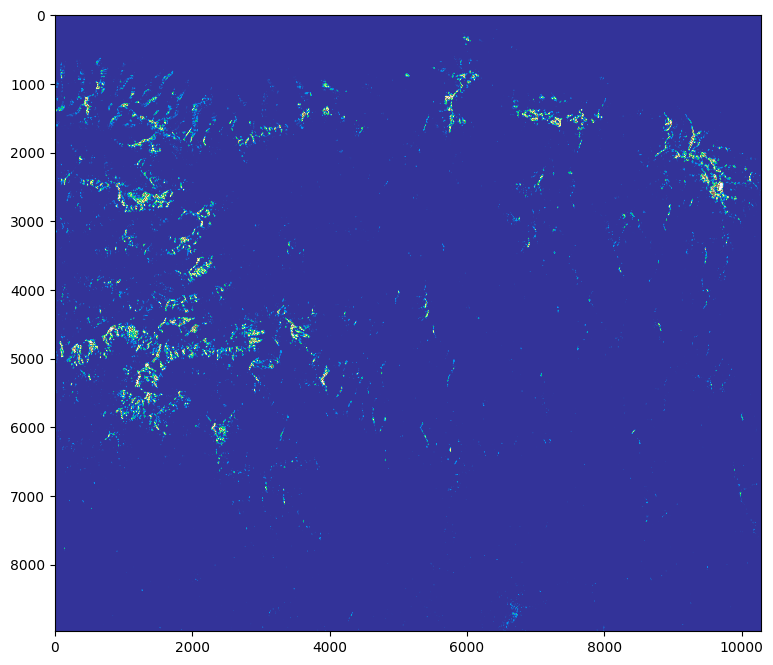

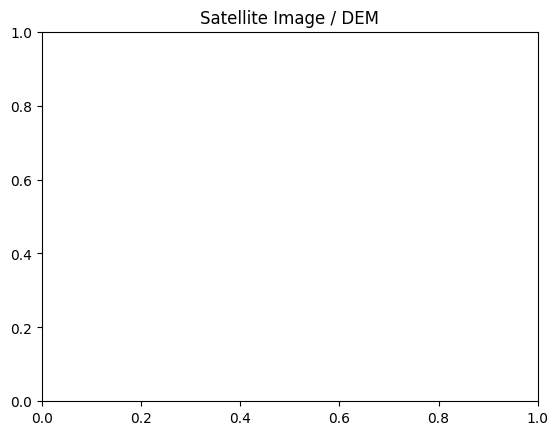

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import folium

flood_data = gpd.read_file('/kaggle/working/processed_flood_data.geojson')

# Load satellite image or DEM (Digital Elevation Model)
with rasterio.open('/kaggle/input/flood-data-sikkim/flood_data_sikkim.tif') as src:
    satellite_img = src.read(1)
    satellite_meta = src.meta

# Plot the satellite image
plt.figure(figsize=(10, 8))
show(satellite_img, cmap='terrain')
plt.title('Satellite Image / DEM')
plt.show()


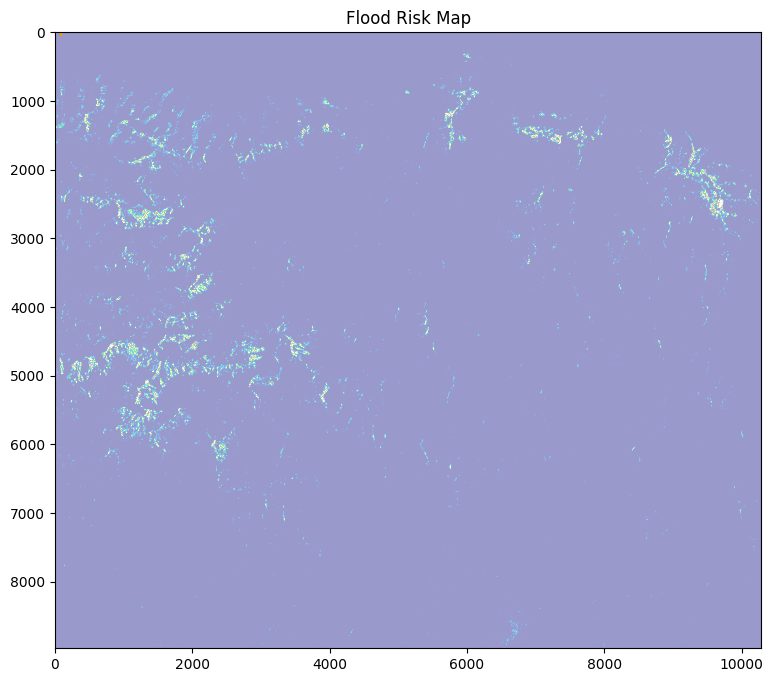

In [73]:
# Plot flood risk areas on top of the satellite image
fig, ax = plt.subplots(figsize=(10, 8))
flood_data.plot(ax=ax, color='orange', alpha=0.6)
show(satellite_img, ax=ax, cmap='terrain', alpha=0.5)
plt.title('Flood Risk Map')
plt.show()

In [81]:
flood_data_path = '/kaggle/input/flood-data-sikkim/flood_data_sikkim.tif'

with rasterio.open(flood_data_path) as src:
    flood_data = src.read(1)  # Read the first band
    bounds = src.bounds  # Get image bounds
    transform = src.transform

# Define a function to convert raster data to an image overlay
def raster_to_image(raster_data, transform, output_path):
    """Convert raster data to an image overlay for folium."""
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(raster_data, cmap='Blues', interpolation='none')
    ax.set_title('Flood Data')
    plt.colorbar(cax, ax=ax)
    plt.axis('off')

    # Save plot to a file
    plt.savefig(output_path, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

# Path to save the image
image_path = '/kaggle/working/flood_data_sikkim_image.png'

# Convert raster data to image file
raster_to_image(flood_data, transform, image_path)

# Create a folium map centered around the ROI
map_center = [(27.707 + 28.052) / 2, (88.021 + 88.942) / 2]
m = folium.Map(location=map_center, zoom_start=10)

# Add the image overlay to the map
folium.raster_layers.ImageOverlay(
    image=image_path,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    opacity=0.6,
    name='Flood Data'
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save map to HTML
map_html_path = '/kaggle/working/flood_data_sikkim_map.html'
m.save(map_html_path)

# Display the path to the saved map
map_html_path

'/kaggle/working/flood_data_sikkim_map.html'